<a href="https://colab.research.google.com/github/ziyuezhao1/ddpm/blob/main/DDPMminist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 模型

In [1]:
# no problem
import os
import math
from abc import abstractmethod

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# 无需更改

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    Args:
        timesteps (Tensor): a 1-D Tensor of N indices, one per batch element. These may be fractional.
        dim (int): the dimension of the output.
        max_period (int, optional): controls the minimum frequency of the embeddings. Defaults to 10000.

    Returns:
        Tensor: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t):
        """
        Apply the module to `x` given `t` timestep embeddings.
        """
        pass

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t)
            else:
                x = layer(x)
        return x

def norm_layer(channels):
    return nn.GroupNorm(32, channels)

class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Attention block with shortcut

        Args:
            channels (int): channels
            num_heads (int, optional): attention heads. Defaults to 1.
        """
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x


class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding
    """
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            timesteps (Tensor): a 1-D batch of timesteps.

        Returns:
            Tensor: [N x C x ...]
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)


def linear_beta_schedule(timesteps):
    """
    beta schedule
    """
    scale = 10 / timesteps
    beta_start = scale * 0.01
    beta_end = scale * 0.9
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections.abc import Iterable
from itertools import repeat

DEFAULT_DTYPE = torch.float32


def DEFAULT_INITIALIZER(x, scale=1.):
    """
    PyTorch Xavier uniform initialization: w ~ Uniform(-a, a), where a = gain * (6 / (fan_in + fan_out)) ** .5
    TensorFlow Variance-Scaling initialization (mode="fan_avg", distribution="uniform"):
    w ~ Uniform(-a, a), where a = (6 * scale / (fan_in + fan_out)) ** .5
    Therefore, gain = scale ** .5
    """
    return nn.init.xavier_uniform_(x, gain=math.sqrt(scale or 1e-10))


def ntuple(n, name="parse"):
    def parse(x):
        if isinstance(x, Iterable):
            return tuple(x)
        else:
            return tuple(repeat(x, n))
    parse.__name__ = name
    return parse


pair = ntuple(2, "pair")


class Linear(nn.Module):
    def __init__(
            self,
            in_features,
            out_features,
            bias=True,
            init_scale=1.
    ):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty((out_features, in_features), dtype=DEFAULT_DTYPE))
        if bias:
            self.bias = nn.Parameter(torch.empty((out_features, ), dtype=DEFAULT_DTYPE))
        else:
            self.register_parameter('bias', None)
        self.init_scale = init_scale
        self.reset_parameters()

    def reset_parameters(self):
        DEFAULT_INITIALIZER(self.weight, scale=self.init_scale)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None)


class Conv2d(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            groups=1,
            bias=True,
            padding_mode="zeros",
            init_scale=1.
    ):
        super(Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size = pair(kernel_size)
        self.weight = nn.Parameter(
            torch.empty((
                out_channels, in_channels // groups, kernel_size[0], kernel_size[1]
            ), dtype=DEFAULT_DTYPE))
        if bias:
            self.bias = nn.Parameter(torch.empty((out_channels, ), dtype=DEFAULT_DTYPE))
        else:
            self.register_parameter("bias", None)
        self.stride = pair(stride)
        self.padding = padding if isinstance(padding, str) else pair(padding)
        self.dilation = pair(dilation)
        self.groups = groups
        self.padding_mode = padding_mode
        self.init_scale = init_scale
        self.reset_parameter()

    def reset_parameter(self):
        DEFAULT_INITIALIZER(self.weight, scale=self.init_scale)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def forward(self, x):
        return F.conv2d(
            x, self.weight, self.bias, stride=self.stride, padding=self.padding,
            dilation=self.dilation, groups=self.groups)


class ValidPad2d(nn.Module):
    def __init__(self, kernel_size, stride, mode="constant", value=0.0):
        super(ValidPad2d, self).__init__()
        self.kernel_size = pair(kernel_size)
        self.stride = pair(stride)
        self.mode = mode
        self.value = value

    def forward(self, x):
        _, _, h, w = x.shape
        (k1, k2), (s1, s2) = self.kernel_size, self.stride
        h_pad, w_pad = s1 * math.ceil((h - k1 + 1) / s1 - 1) + k1 - h, \
                       s2 * math.ceil((w - k2 + 1) / s2 - 1) + k2 - w
        top_pad, bottom_pad = (math.floor(h_pad / 2), math.ceil(h_pad / 2)) if h_pad else (0, 0)
        left_pad, right_pad = (math.floor(w_pad / 2), math.ceil(w_pad / 2)) if w_pad else (0, 0)
        x = F.pad(x, pad=(left_pad, right_pad, top_pad, bottom_pad), mode=self.mode, value=self.value)
        return x


class SamePad2d(nn.Module):
    def __init__(self, kernel_size, stride, mode="constant", value=0.0):
        super(SamePad2d, self).__init__()
        self.kernel_size = pair(kernel_size)
        self.stride = pair(stride)
        self.mode = mode
        self.value = value

    def forward(self, x):
        _, _, h, w = x.shape
        (k1, k2), (s1, s2) = self.kernel_size, self.stride
        h_pad, w_pad = s1 * math.ceil(h / s1 - 1) + k1 - h, s2 * math.ceil(w / s2 - 1) + k2 - w
        top_pad, bottom_pad = (math.floor(h_pad / 2), math.ceil(h_pad / 2)) if h_pad else (0, 0)
        left_pad, right_pad = (math.floor(w_pad / 2), math.ceil(w_pad / 2)) if w_pad else (0, 0)
        x = F.pad(x, pad=(left_pad, right_pad, top_pad, bottom_pad), mode=self.mode, value=self.value)
        return x


class Sequential(nn.Sequential):
    def forward(self, input, **kwargs):
        for module in self:
            input = module(input, **kwargs)
        return input

In [4]:
import math
import numpy as np
import torch
import torch.nn.functional as F
from typing import Union, Tuple

DEFAULT_DTYPE = torch.float32

@torch.jit.script
def get_timestep_embedding(timesteps, embed_dim: int, dtype: torch.dtype = DEFAULT_DTYPE):
    """
    Adapted from fairseq/fairseq/modules/sinusoidal_positional_embedding.py
    The implementation is slightly different from the decription in Section 3.5 of [1]
    [1] Vaswani, Ashish, et al. "Attention is all you need."
     Advances in neural information processing systems 30 (2017).
    """
    half_dim = embed_dim // 2
    embed = math.log(10000) / (half_dim - 1)
    embed = torch.exp(-torch.arange(half_dim, dtype=dtype, device=timesteps.device) * embed)
    embed = torch.outer(timesteps.ravel().to(dtype), embed)
    embed = torch.cat([torch.sin(embed), torch.cos(embed)], dim=1)
    if embed_dim % 2 == 1:
        embed = F.pad(embed, [0, 1])  # padding the last dimension
    assert embed.dtype == dtype
    return embed


@torch.jit.script
def normal_kl(mean1, logvar1, mean2, logvar2):
    diff_logvar = logvar1 - logvar2
    kl = (-1.0 - diff_logvar).add(
        (mean1 - mean2).pow(2) * torch.exp(-logvar2)).add(
        torch.exp(diff_logvar)).mul(0.5)
    return kl


@torch.jit.script
def approx_std_normal_cdf(x):
    """
    Reference:
    Page, E. “Approximations to the Cumulative Normal Function and Its Inverse for Use on a Pocket Calculator.”
     Applied Statistics 26.1 (1977): 75–76. Web.
    """
    return 0.5 * (1. + torch.tanh(math.sqrt(2. / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


@torch.jit.script
def discretized_gaussian_loglik(
        x, means, log_scale, precision: float = 1./255,
        cutoff: Union[float, Tuple[float, float]] = (-0.999, 0.999), tol: float = 1e-12):
    if isinstance(cutoff, float):
        cutoff = (-cutoff, cutoff)
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    x_centered = x - means
    inv_stdv = torch.exp(-log_scale)
    upper = inv_stdv * (x_centered + precision)
    cdf_upper = torch.where(
        x > cutoff[1], torch.as_tensor(1, dtype=torch.float32, device=x.device), approx_std_normal_cdf(upper))
    lower = inv_stdv * (x_centered - precision)
    cdf_lower = torch.where(
        x < cutoff[0], torch.as_tensor(0, dtype=torch.float32, device=x.device), approx_std_normal_cdf(lower))
    log_probs = torch.log(torch.clamp(cdf_upper - cdf_lower - tol, min=0).add(tol))
    return log_probs


@torch.jit.script
def continuous_gaussian_loglik(x, mean, logvar):
    x_centered = x - mean
    inv_var = torch.exp(-logvar)
    log_probs = x_centered.pow(2) * inv_var + math.log(2 * math.pi) + logvar
    return log_probs.mul(0.5).neg()


def discrete_klv2d(hist1, hist2, eps=1e-9):
    """
    compute the discretized (empirical) Kullback-Leibler divergence between P_data1 and P_data2
    """
    return np.sum(hist2 * (np.log(hist2 + eps) - np.log(hist1 + eps)))


def hist2d(data, bins, value_range=None):
    """
    compute the 2d histogram matrix for a set of data points
    """
    if bins == "auto":
        bins = math.floor(math.sqrt(len(data) // 10))
    if value_range is not None:
        if isinstance(value_range, (int, float)):
            value_range = ((-value_range, value_range), ) * 2
        if hasattr(value_range, "__iter__"):
            if not hasattr(next(iter(value_range)), "__iter__"):
                value_range = (value_range, ) * 2
    x, y = np.split(data, 2, axis=1)
    x, y = x.squeeze(1), y.squeeze(1)
    return np.histogram2d(x, y, bins=bins, range=value_range)[0]


def flat_mean(x, start_dim=1):
    reduce_dim = [i for i in range(start_dim, x.ndim)]
    return torch.mean(x, dim=reduce_dim)


def flat_sum(x, start_dim=1):
    reduce_dim = [i for i in range(start_dim, x.ndim)]
    return torch.sum(x, dim=reduce_dim)

In [5]:
import math
import torch
import torch.nn as nn


DEFAULT_NONLINEARITY = nn.SiLU()  # f(x)=x*sigmoid(x)


class DEFAULT_NORMALIZER(nn.GroupNorm):
    def __init__(self, num_channels, num_groups=32):
        super().__init__(num_groups=num_groups, num_channels=num_channels, eps=1e-6)  # PyTorch default eps is 1e-5


class AttentionBlock(nn.Module):
    normalize = DEFAULT_NORMALIZER

    def __init__(
            self,
            in_channels,
            mid_channels=None,
            out_channels=None
    ):
        super(AttentionBlock, self).__init__()
        mid_channels = mid_channels or in_channels
        out_channels = out_channels or in_channels
        self.norm = self.normalize(in_channels)
        self.project_in = Conv2d(in_channels, 3 * mid_channels, 1)
        self.project_out = Conv2d(mid_channels, out_channels, 1, init_scale=0.)
        self.in_channels = in_channels
        self.mid_channels = mid_channels
        self.out_channels = out_channels
        self.skip = nn.Identity() if in_channels == out_channels else Conv2d(in_channels, out_channels, 1)

    @staticmethod
    def qkv(q, k, v):
        B, C, H, W = q.shape
        w = torch.einsum("bchw, bcHW -> bhwHW", q, k)
        w = torch.softmax(
            w.reshape(B, H, W, H * W) / math.sqrt(C), dim=-1
        ).reshape(B, H, W, H, W)
        out = torch.einsum("bhwHW, bcHW -> bchw", w, v)  # this will break the contiguity -> impaired performance
        return out.contiguous()  # force to return a contiguous tensor

    def forward(self, x, **kwargs):
        skip = self.skip(x)
        C = x.shape[1]
        assert C == self.in_channels
        q, k, v = self.project_in(self.norm(x)).chunk(3, dim=1)
        x = self.qkv(q, k, v)
        x = self.project_out(x)
        return x + skip


class ResidualBlock(nn.Module):
    normalize = DEFAULT_NORMALIZER
    nonlinearity = DEFAULT_NONLINEARITY

    def __init__(
            self,
            in_channels,
            out_channels,
            embed_dim,
            drop_rate=0.
    ):
        super(ResidualBlock, self).__init__()
        self.norm1 = self.normalize(in_channels)
        self.conv1 = Conv2d(in_channels, out_channels, 3, 1, 1)
        self.fc = Linear(embed_dim, out_channels)
        self.norm2 = self.normalize(out_channels)
        self.conv2 = Conv2d(out_channels, out_channels, 3, 1, 1, init_scale=0.)
        self.skip = nn.Identity() if in_channels == out_channels else Conv2d(in_channels, out_channels, 1)
        self.dropout = nn.Dropout(p=drop_rate, inplace=True)

    def forward(self, x, t_emb):
        skip = self.skip(x)
        x = self.conv1(self.nonlinearity(self.norm1(x)))
        x += self.fc(self.nonlinearity(t_emb))[:, :, None, None]
        x = self.dropout(self.nonlinearity(self.norm2(x)))
        x = self.conv2(x)
        return x + skip


class UNet(nn.Module):
    normalize = DEFAULT_NORMALIZER
    nonlinearity = DEFAULT_NONLINEARITY

    def __init__(
            self,
            in_channels,
            hid_channels,
            out_channels,
            ch_multipliers,
            num_res_blocks,
            apply_attn,
            time_embedding_dim=None,
            drop_rate=0.,
            resample_with_conv=True
    ):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.hid_channels = hid_channels
        self.out_channels = out_channels
        self.time_embedding_dim = time_embedding_dim or 4 * self.hid_channels
        levels = len(ch_multipliers)
        self.ch_multipliers = ch_multipliers
        if isinstance(apply_attn, bool):
            apply_attn = [apply_attn for _ in range(levels)]
        self.apply_attn = apply_attn
        self.num_res_blocks = num_res_blocks
        self.drop_rate = drop_rate
        self.resample_with_conv = resample_with_conv

        self.embed = Sequential(
            Linear(self.hid_channels, self.time_embedding_dim),
            self.nonlinearity,
            Linear(self.time_embedding_dim, self.time_embedding_dim)
        )
        self.in_conv = Conv2d(in_channels, hid_channels, 3, 1, 1)
        self.levels = levels
        self.downsamples = nn.ModuleDict({f"level_{i}": self._get_downsample_by_level(i) for i in range(levels)})
        mid_channels = ch_multipliers[-1] * hid_channels
        embed_dim = self.time_embedding_dim
        self.middle = Sequential(
            ResidualBlock(mid_channels, mid_channels, embed_dim=embed_dim, drop_rate=drop_rate),
            AttentionBlock(mid_channels),
            ResidualBlock(mid_channels, mid_channels, embed_dim=embed_dim, drop_rate=drop_rate)
        )
        self.upsamples = nn.ModuleDict({f"level_{i}": self._get_upsample_by_level(i) for i in range(levels)})
        self.out_conv = Sequential(
            self.normalize(hid_channels),
            self.nonlinearity,
            Conv2d(hid_channels, out_channels, 3, 1, 1, init_scale=0.)
        )

    def _get_block_by_level(self, level):
        block_kwargs = {"embed_dim": self.time_embedding_dim, "drop_rate": self.drop_rate}
        if self.apply_attn[level]:
            def block(in_chans, out_chans):
                return Sequential(
                    ResidualBlock(in_chans, out_chans, **block_kwargs),
                    AttentionBlock(out_chans))
        else:
            def block(in_chans, out_chans):
                return ResidualBlock(in_chans, out_chans, **block_kwargs)
        return block

    def _get_downsample_by_level(self, level):
        block = self._get_block_by_level(level)
        prev_chans = (self.ch_multipliers[level-1] if level else 1) * self.hid_channels
        curr_chans = self.ch_multipliers[level] * self.hid_channels
        modules = nn.ModuleList([block(prev_chans, curr_chans)])
        for _ in range(self.num_res_blocks - 1):
            modules.append(block(curr_chans, curr_chans))
        if level != self.levels - 1:
            if self.resample_with_conv:
                downsample = Sequential(
                    SamePad2d(3, 2),  # custom same padding
                    Conv2d(curr_chans, curr_chans, 3, 2))
            else:
                downsample = nn.AvgPool2d(2)
            modules.append(downsample)
        return modules

    def _get_upsample_by_level(self, level):
        block = self._get_block_by_level(level)
        ch = self.hid_channels
        chs = list(map(lambda x: ch * x, self.ch_multipliers))
        next_chans = ch if level == 0 else chs[level - 1]
        prev_chans = chs[-1] if level == self.levels - 1 else chs[level + 1]
        curr_chans = chs[level]
        modules = nn.ModuleList([block(prev_chans + curr_chans, curr_chans)])
        for _ in range(self.num_res_blocks - 1):
            modules.append(block(2 * curr_chans, curr_chans))
        modules.append(block(next_chans + curr_chans, curr_chans))
        if level != 0:
            """
            Note: the official TensorFlow implementation specifies `align_corners=True`
            However, PyTorch does not support align_corners for nearest interpolation
            to see the difference, run the following example:
            ---------------------------------------------------------------------------
            import numpy as np
            import torch
            import tensorflow as tf

            x = np.arange(9.).reshape(3, 3)
            print(torch.nn.functional.interpolate(torch.as_tensor(x).reshape(1, 1, 3, 3), size=7, mode="nearest"))  # asymmetric
            print(tf.squeeze(tf.compat.v1.image.resize(tf.reshape(tf.convert_to_tensor(x), shape=(3, 3, 1)), size=(7, 7), method="nearest", align_corners=True)))  # symmetric
            ---------------------------------------------------------------------------
            """  # noqa
            upsample = [nn.Upsample(scale_factor=2, mode="nearest")]
            if self.resample_with_conv:
                upsample.append(Conv2d(curr_chans, curr_chans, 3, 1, 1))
            modules.append(Sequential(*upsample))
        return modules

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.hid_channels)
        t_emb = self.embed(t_emb)

        # downsample
        hs = [self.in_conv(x)]
        for i in range(self.levels):
            downsample = self.downsamples[f"level_{i}"]
            for j, layer in enumerate(downsample):  # noqa
                h = hs[-1]
                if j != self.num_res_blocks:
                    hs.append(layer(h, t_emb=t_emb))
                else:
                    hs.append(layer(h))

        # middle
        h = self.middle(hs[-1], t_emb=t_emb)

        # upsample
        for i in range(self.levels-1, -1, -1):
            upsample = self.upsamples[f"level_{i}"]
            for j, layer in enumerate(upsample):  # noqa
                if j != self.num_res_blocks + 1:
                    h = layer(torch.cat([h, hs.pop()], dim=1), t_emb=t_emb)
                else:
                    h = layer(h)

        h = self.out_conv(h)
        return h


In [6]:
# 需要更改

class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=0.99)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        # get the param of given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        # forward diffusion (using the nice property): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def q_mean_variance(self, x_start, t):
        # Get the mean and variance of q(x_t | x_0).
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t, t, noise):
        # compute x_0 from x_t and pred noise: the reverse of `q_sample`

        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    def predict_t_1_from_t(self, x_t, noise,t):
        # compute x_t_1 from x_t and pred noise: the reverse of `q_sample`
        #print(self.alphas[t].to(x_t.device).device)
        #print(self.betas[t].to(x_t.device).device)
        return (
            (1.0/self.alphas[t].to(x_t.device)) * (x_t -
            self.betas[t].to(x_t.device) * noise)
        )

    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # compute predicted mean and variance of p(x_{t-1} | x_t)
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)

        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # denoise_step: sample x_{t-1} from x_t and pred_noise
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        # denoise: reverse diffusion
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs

    @torch.no_grad()
    def p_sample_loop_new(self, model, image):
        # denoise: reverse diffusion
        batch_size = image.shape[0]
        device = next(model.parameters()).device
        img=image
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs


    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        # sample new images
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))



    def train_losses(self, model, x_start, t):
        # compute train losses
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

    def get_parameter(self, model, x_start, t):
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)

        predicted_noise = model(x_noisy, t)

        alphas=self.alphas.to(t.device)
        betas=self.betas.to(t.device)

        sqrt_one_minus_alphas_cumprod=self.sqrt_one_minus_alphas_cumprod.to(t.device)
        mean1,variance_all,posterior_log_variance=self.p_mean_variance(model, x_noisy, t)

        #mean1=alphas[t]*x_noisy-predicted_noise*betas[t]/sqrt_one_minus_alphas_cumprod

        return mean1,variance_all

    def get_parameter2(self, model, x_t, t):
        # get x_t
        #predicted_noise = model(x_t, t)
        #noise = torch.randn_like(x_final)

        predicted_noise = model(x_t, t)

        alphas=self.alphas.to(t.device)
        betas=self.betas.to(t.device)

        sqrt_one_minus_alphas_cumprod=self.sqrt_one_minus_alphas_cumprod.to(t.device)
        mean1,variance_all,posterior_log_variance=self.p_mean_variance(model, x_t, t)

        #mean1=alphas[t]*x_noisy-predicted_noise*betas[t]/sqrt_one_minus_alphas_cumprod

        return mean1,variance_all


看看效果

In [7]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

%matplotlib inline

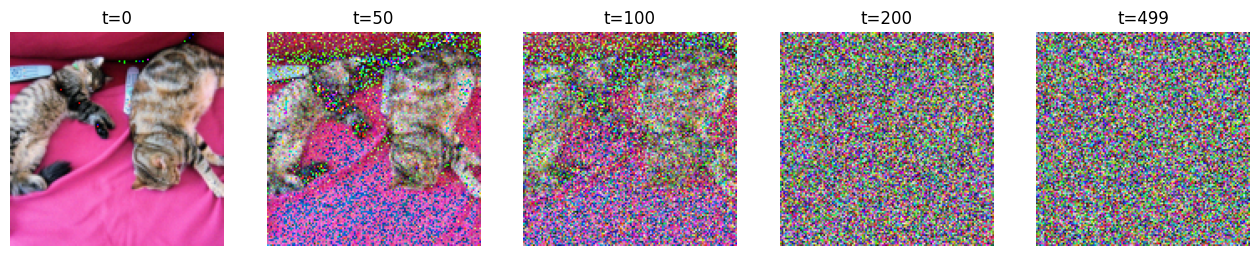

In [8]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("/data/000000039769.jpg")

image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

## 训练

准备数据集

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [10]:
class TrainSet(Dataset):
  def __init__(self, original_dataset,label):
    self.original_dataset = original_dataset
    self.label = label

  def __getitem__(self, index):
      image = self.original_dataset[index]
      return image, self.label[index]

  def __len__(self):
      return len(self.original_dataset)

In [11]:
class BinaryDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset,indices,label):
        self.original_dataset = original_dataset
        self.indices  = indices
        self.label = label

    def __getitem__(self, index):
        image, _ = self.original_dataset[self.indices[index]]
        return image, self.label

    def __len__(self):
        return len(self.indices)

In [23]:
batch_size = 64
timesteps = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

In [27]:
mnist_indices = [i for i in range(len(dataset)) if dataset[i][1] == 3]
mnist2_indices = [i for i in range(len(dataset)) if dataset[i][1] == 5]
dataset_image_number=256

mnist_dataset = BinaryDataset(dataset, mnist_indices[0:dataset_image_number],label=3)
mnist2_dataset = BinaryDataset(dataset, mnist2_indices[0:dataset_image_number],label=5 )

mnist_dataset_v = BinaryDataset(dataset, mnist_indices[dataset_image_number+1:2*dataset_image_number],label=3)
mnist2_dataset_v = BinaryDataset(dataset, mnist2_indices[dataset_image_number+1:2*dataset_image_number],label=5 )

In [28]:
len(mnist_indices)

6131

In [29]:
mnist_dataset_v = BinaryDataset(dataset, mnist_indices[dataset_image_number+1:2*dataset_image_number],label=3)
mnist2_dataset_v = BinaryDataset(dataset, mnist2_indices[dataset_image_number+1:2*dataset_image_number],label=5 )

In [30]:
train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])

val_dataset=torch.utils.data.ConcatDataset([mnist_dataset_v, mnist2_dataset_v])
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True,pin_memory=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
torch.Size([1, 28, 28])


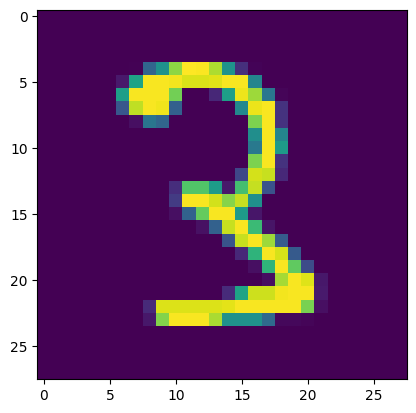

In [35]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1]
label = train_labels[0]
print(img.size())
plt.imshow(torch.permute(img, (1,2,0)))
plt.savefig('savefig_example_minist4.png')
plt.show()

模型

开始训练

In [36]:
import torch,gc
gc.collect()
torch.cuda.empty_cache()
from torch.utils.data import Dataset

In [37]:
# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)

In [39]:
epochs = 10
model = UNet(1, 96, 1, (1, 2, 2), 2, (False, True, False))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
timesteps = 5
loss_batch_average=torch.zeros([epochs,timesteps,int(dataset_image_number/batch_size)])
model_parameters=dict()
x_t_train_dataset1=torch.utils.data.ConcatDataset([mnist_dataset])
x_t_train_dataset2=torch.utils.data.ConcatDataset([mnist2_dataset])
losses = {'loss':[],'loss2':[]}
best_acc=0
for t in range(timesteps-1,-1,-1):
  time = torch.full((batch_size,),t, device=device).long()

  train_loader1 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=True,pin_memory=True)
  train_loader2 = torch.utils.data.DataLoader(x_t_train_dataset2, batch_size=batch_size, shuffle=True,pin_memory=True)
  for epoch in range(epochs):
    batch_size=batch_size
    iteration_of_train_loader2=iter(train_loader2)
    for step, (images1, _) in enumerate(train_loader1):

      xt1 = images1.to(device)
      images2,_=next(iteration_of_train_loader2)
      xt2 = images2.to(device)

      out1 = model(xt1, time)
      out2 = model(xt2, time)
      out1=transforms.Normalize((0.5), (0.5))(out1)
      out2=transforms.Normalize((0.5), (0.5))(out2)

      m1 =out1.reshape(batch_size,1*28*28)
      m2 =out2.reshape(batch_size,1*28*28)

      s1=torch.var(m1, dim=0)
      s2=torch.var(m2, dim=0)
      loss2=s1.mean(0)+s2.mean(0)
      loss=0.1*loss2+torch.dot(m1.mean(0) / torch.norm(m1.mean(0)), m2.mean(0) / torch.norm(m2.mean(0)))

      loss_batch_average[epoch,t,step]=loss
      del s1,s2,m1,m2
      print(" this is timesteps",t," this is epoch",epoch,"this is step ",step)
      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
      losses['loss'].append(loss.detach().cpu().numpy())
      losses['loss2'].append(loss2.detach().cpu().numpy())

      loss_batch_average[epoch,t,step]=loss
      #for name, parms in model.named_parameters():
        #print('-->name:', name, '-->grad_requirs:',parms.requires_grad, ' -->grad_value:',parms.grad)
      # print('-->name:', name, parms.data)

      print("loss",loss)
      print("loss2",loss2)
      model_parameters[t]=model.state_dict()

  x_t_train_dataset1_1=torch.zeros([dataset_image_number,1,28,28])
  x_t_train_dataset2_2=torch.zeros([dataset_image_number,1,28,28])

  labels_1=torch.zeros([dataset_image_number])
  labels_2=torch.zeros([dataset_image_number])
  #establish xt_1 for the next loop
  with torch.no_grad():
    for step, (images1, labels) in enumerate(train_loader1):
      xt1 = images1.to(device)

      images1=transforms.Normalize((0.5), (0.5))(model(xt1, time))

      x_t_train_dataset1_1[step*batch_size:(step+1)*batch_size,:,:,:]=images1
      labels_1[step*batch_size:(step+1)*batch_size]=labels
    x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset1_1,labels_1)])

  with torch.no_grad():
    for step, (images2, labels2) in enumerate(train_loader2):
      xt2 = images2.to(device)

      images2= transforms.Normalize((0.5), (0.5))(model(xt2, time))

      x_t_train_dataset2_2[step*batch_size:(step+1)*batch_size,:,:,:]=images2
      labels_2[step*batch_size:(step+1)*batch_size]=labels2
    x_t_train_dataset2=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset2_2,labels_2)])

  model.eval()
  #establish xt_1 for the next loop
  val_acc=0
  with torch.no_grad():
    for step, (image, label) in enumerate(val_loader):
      image = image.to(device)
      x0=image
      for t_v in range(timesteps-1,t-1,-1):

        model.load_state_dict(model_parameters[t_v],strict=True)
        time=torch.full((1,),t_v, device=device)
        x=model(x0, time)
        x0=transforms.Normalize((0.5), (0.5))(x).to(device)

      a=torch.dot(x_t_train_dataset1_1.reshape(dataset_image_number,1*28*28).mean(0).to(device) / torch.norm(x_t_train_dataset1_1.reshape(dataset_image_number,1*28*28).mean(0)).to(device), x0.reshape(1,1*28*28).mean(0).to(device) / torch.norm(x0.reshape(1,1*28*28).mean(0)).to(device)).to(device)# distance between 3 and pred
      b=torch.dot(x_t_train_dataset2_2.reshape(dataset_image_number,1*28*28).mean(0).to(device) / torch.norm(x_t_train_dataset2_2.reshape(dataset_image_number,1*28*28).mean(0)).to(device), x0.reshape(1,1*28*28).mean(0).to(device) / torch.norm(x0.reshape(1,1*28*28).mean(0)).to(device)).to(device)# distance between 2 and pred
      if a >= b:
        pred_label= 3
        #print(a,"and",b)
      else:
        pred_label= 5
        #print(a,"and",b)
      if pred_label==label:
        val_acc=val_acc+1
        #print("exact!", pred_label,"the true is ",label)
      else:
        print("find different label at step ", step, pred_label,"the true is ",label)
    print("val_acc",val_acc/len(val_dataset))
    if val_acc/len(val_dataset)>best_acc:
      best_acc=val_acc/len(val_dataset)
      print(best_acc)
      epochs_without_improvement = 0
    else:
      epochs_without_improvement+=1
      print("early stopping at timestep", t,val_acc/len(val_dataset))
      #break
  print("done")

 this is timesteps 4  this is epoch 0 this is step  0
loss tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
loss2 tensor(3.5575e-10, device='cuda:0', grad_fn=<AddBackward0>)
 this is timesteps 4  this is epoch 0 this is step  1
loss tensor(1.0001, device='cuda:0', grad_fn=<AddBackward0>)
loss2 tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)
 this is timesteps 4  this is epoch 0 this is step  2
loss tensor(0.9997, device='cuda:0', grad_fn=<AddBackward0>)
loss2 tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
 this is timesteps 4  this is epoch 0 this is step  3
loss tensor(0.9983, device='cuda:0', grad_fn=<AddBackward0>)
loss2 tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)
 this is timesteps 4  this is epoch 1 this is step  0
loss tensor(0.9304, device='cuda:0', grad_fn=<AddBackward0>)
loss2 tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)
 this is timesteps 4  this is epoch 1 this is step  1
loss tensor(0.9103, device='cuda:0', grad_fn=<AddBackward0>)


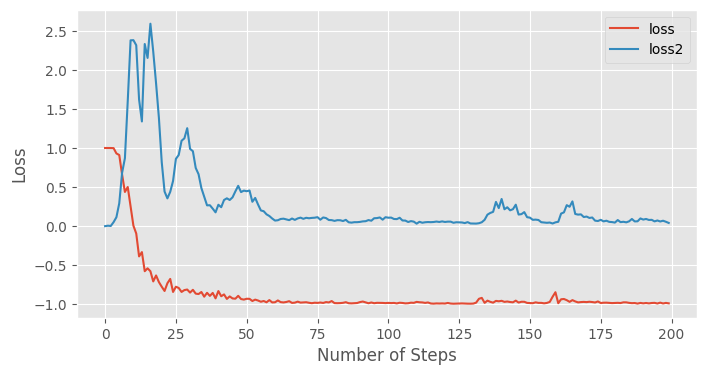

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses, y_axis_label, x_axis_label):

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8,4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel(x_axis_label)
    ax_1.set_ylabel(y_axis_label)
plot_stats_in_graph(losses, y_axis_label='Loss', x_axis_label='Number of Steps')
plt.savefig('savefig_example_fortotalloss.png')

torch.Size([10, 5])


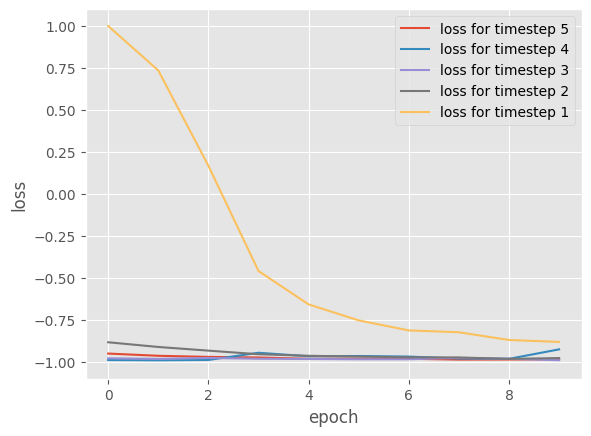

In [41]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
epochs_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(-1.1,1.1)
plt.plot(epochs_list,a.detach().numpy(),label = ['loss for timestep 5','loss for timestep 4','loss for timestep 3','loss for timestep 2','loss for timestep 1'])
plt.legend()
plt.savefig('savefig_example_forloss.png')
plt.show()

torch.Size([10, 5])


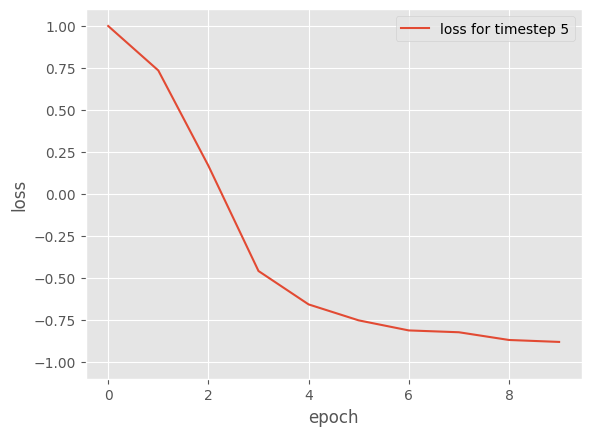

In [42]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
timesteps_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.ylim(-1.1,1.1)
plt.plot(timesteps_list,a[:,4].detach().numpy(),label = 'loss for timestep 5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('savefig_example_forloss_timestep1.png')
plt.show()

torch.Size([10, 5])


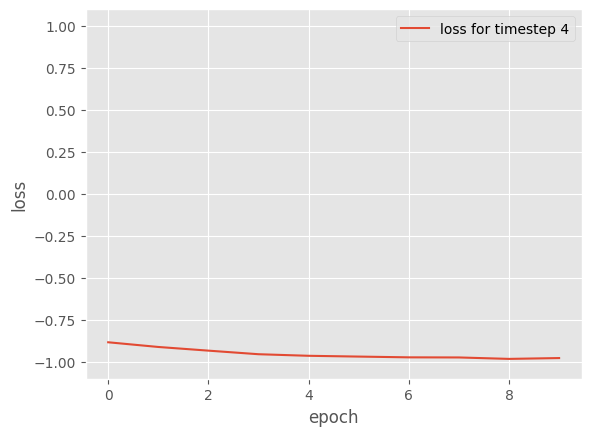

In [43]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
timesteps_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.ylim(-1.1,1.1)
plt.plot(timesteps_list,a[:,3].detach().numpy(),label = 'loss for timestep 4')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('savefig_example_forloss_timestep2.png')
plt.show()

torch.Size([10, 5])


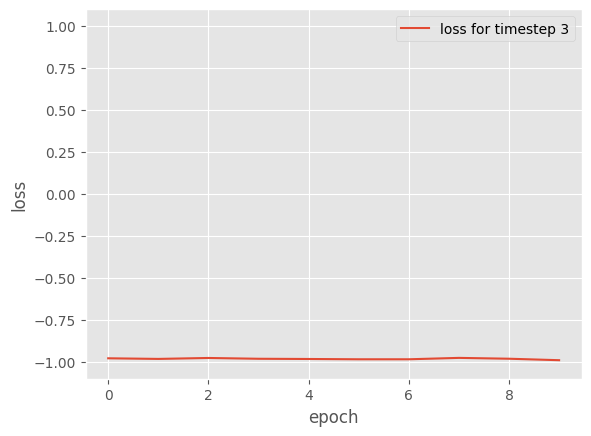

In [44]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
timesteps_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.ylim(-1.1,1.1)
plt.plot(timesteps_list,a[:,2].detach().numpy(),label = 'loss for timestep 3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('savefig_example_forloss_timestep3.png')
plt.show()

torch.Size([10, 5])


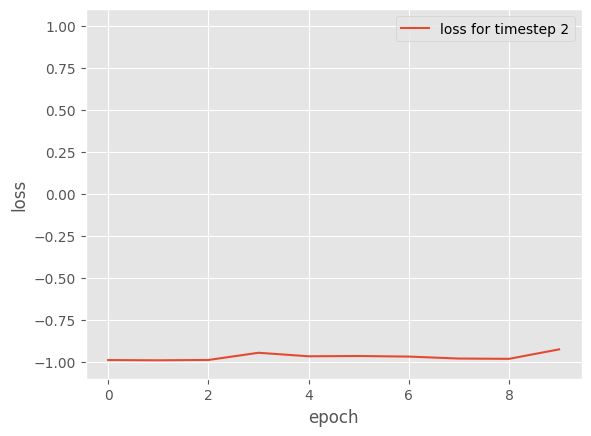

In [45]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
timesteps_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.ylim(-1.1,1.1)
plt.plot(timesteps_list,a[:,1].detach().numpy(),label = 'loss for timestep 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('savefig_example_forloss_timestep4.png')
plt.show()

torch.Size([10, 5])


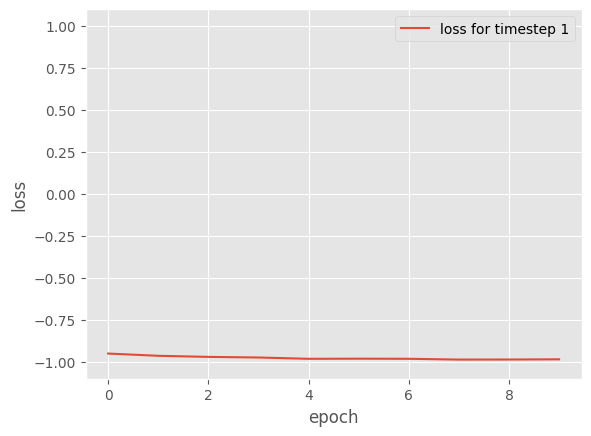

In [46]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
timesteps_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.ylim(-1.1,1.1)
plt.plot(timesteps_list,a[:,0].detach().numpy(),label = 'loss for timestep 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('savefig_example_forloss_timestep5.png')
plt.show()

## 测试

In [47]:
# direct calculate the distance and compare them for original images
batch_size=256
train_dataset1 = torch.utils.data.ConcatDataset([mnist_dataset])# this is label 3
train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size, shuffle=True,pin_memory=True)
x_=torch.zeros([dataset_image_number,1,28,28])
for step, (images, labels) in enumerate(train_loader1):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    x_[step*batch_size:(step+1)*batch_size,:,:,:]=images
x_general=x_[0].mean(0)
print(x_general.shape)
print(x_.shape)

torch.Size([28, 28])
torch.Size([256, 1, 28, 28])


In [48]:
# direct calculate the distance and compare them for original images
batch_size=256
train_dataset2 = torch.utils.data.ConcatDataset([mnist2_dataset])# this is label 5
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True,pin_memory=True)
y_=torch.zeros([dataset_image_number,1,28,28])
for step, (images, labels) in enumerate(train_loader2):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    y_[step*batch_size:(step+1)*batch_size,:,:,:]=images
y_general=y_[0].mean(0)
print(y_general.shape)
print(y_.shape)

torch.Size([28, 28])
torch.Size([256, 1, 28, 28])


In [49]:
# direct calculate the distance and compare them for original images
accuaracy=0
train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True,num_workers=4,pin_memory=True)

with torch.no_grad():
  for step, (image, label) in enumerate(train_loader11):
    batch_size = image.shape[0]
    image = image.to(device)
    x0=image
    a=torch.dot(x_.reshape(dataset_image_number,1*28*28).mean(0).to(device) / torch.norm(x_.reshape(dataset_image_number,1*28*28).mean(0)).to(device), x0.reshape(1,1*28*28).mean(0).to(device) / torch.norm(x0.reshape(1,1*28*28).mean(0)).to(device)).to(device)# distance between 3 and pred
    b=torch.dot(y_.reshape(dataset_image_number,1*28*28).mean(0).to(device) / torch.norm(x_.reshape(dataset_image_number,1*28*28).mean(0)).to(device), x0.reshape(1,1*28*28).mean(0).to(device) / torch.norm(x0.reshape(1,1*28*28).mean(0)).to(device)).to(device)# distance between 2 and pred2 and pred
    if a >= b:
      pred_label= 3
      #print(a,"and",b)
    else:
      pred_label= 5
      #print(a,"and",b)
    if pred_label==label:
      accuaracy=accuaracy+1
      #print("exact!", pred_label,"the true is ",label)
print(accuaracy/len(train_dataset))

0.865234375


This is the test

In [53]:
# establish the x0,x1,x2,x3,x4 for class 1 label3
batch_size=256
train_dataset1 = torch.utils.data.ConcatDataset([mnist_dataset])# this is label 3
train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size, shuffle=True,pin_memory=True)
T=torch.full((batch_size,),timesteps-1, device=device)
model = UNet(1, 96, 1, (1, 2, 2), 2, (False, True, False))
timsteps=5
model.to(device)
x_1=torch.zeros([timesteps,dataset_image_number,1,28,28])
for step, (images, labels) in enumerate(train_loader1):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    x0=images
    for t in range(timesteps-1,-1,-1):
      time = torch.full((batch_size,),t, device=device).long()
      # this is label 3
      model.load_state_dict(model_parameters[t],strict=True)
      model.eval()
      time=torch.full((batch_size,),t, device=device)
      x0=transforms.Normalize(0.5, 0.5)(model(x0, time))
      x_1[t,step*batch_size:(step+1)*batch_size,:,:,:]=x0
x_1_general=x_1[0].mean(0)
print(x_1_general.shape)
print(x_1.shape)

torch.Size([1, 28, 28])
torch.Size([5, 256, 1, 28, 28])


In [54]:
# establish the x0,x1,x2,x3,x4 for class 2 label 5
batch_size=256
train_dataset2 = torch.utils.data.ConcatDataset([mnist2_dataset])# this is label 2
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True,pin_memory=True)
T=torch.full((batch_size,),timesteps-1, device=device)
model = UNet(1, 96, 1, (1, 2, 2), 2, (False, True, False))
model.to(device)
x_2=torch.zeros([timesteps,dataset_image_number,1,28,28])
for step, (images, labels) in enumerate(train_loader2):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    x0=images
    for t in range(timesteps-1,-1,-1):
      time = torch.full((batch_size,),t, device=device).long()
      # this is label 5
      model.load_state_dict(model_parameters[t],strict=True)
      model.eval()
      time=torch.full((batch_size,),t, device=device)
      x0=transforms.Normalize(0.5, 0.5)(model(x0, time))
      x_2[t,step*batch_size:(step+1)*batch_size,:,:,:]=x0

x_2_general=x_2[0].mean(0)
print(x_2_general.shape)
print(x_2.shape)

torch.Size([1, 28, 28])
torch.Size([5, 256, 1, 28, 28])


In [55]:
#calculate the mean distance and variances within differenct class
for t in range(timesteps-1,-1,-1):
  innerproduct=torch.dot(x_1[t].reshape(256,1*28*28).mean(0).to(device) / torch.norm(x_1[t].reshape(256,1*28*28).mean(0)).to(device), x_2[t].reshape(256,1*28*28).mean(0).to(device) / torch.norm(x_2[t].reshape(256,1*28*28).mean(0)).to(device)).to(device).mean(0)
  print("inner product",innerproduct)
  m1=x_1[t].reshape(batch_size,1*28*28)
  m2=x_2[t].reshape(batch_size,1*28*28)

  s1=torch.var(m1, dim=0)
  s2=torch.var(m2, dim=0)
  print("variance",s1.mean(0),s2.mean(0))

inner product tensor(-0.8528, device='cuda:0')
variance tensor(0.0295) tensor(0.0215)
inner product tensor(-0.9575, device='cuda:0')
variance tensor(0.0508) tensor(0.0321)
inner product tensor(-0.9540, device='cuda:0')
variance tensor(0.0475) tensor(0.0292)
inner product tensor(-0.9631, device='cuda:0')
variance tensor(0.0595) tensor(0.0310)
inner product tensor(-0.9225, device='cuda:0')
variance tensor(0.0527) tensor(0.0387)


In [56]:
accuaracy=0
train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True,num_workers=4,pin_memory=True)
acc=torch.zeros(timesteps)

with torch.no_grad():
  for step, (image, label) in enumerate(train_loader11):
    batch_size = image.shape[0]
    image = image.to(device)
    x0=image
    for t in range(timesteps-1,-1,-1):

      model.load_state_dict(model_parameters[t],strict=True)
      model.eval()
      time=torch.full((batch_size,),t, device=device)
      x0=transforms.Normalize(0.5, 0.5)(model(x0, time))
      a=torch.dot(x_1[t].reshape(dataset_image_number,1*28*28).mean(0).to(device) / torch.norm(x_1[t].reshape(dataset_image_number,1*28*28).mean(0)).to(device), x0.reshape(1,1*28*28).mean(0).to(device) / torch.norm(x0.reshape(1,1*28*28).mean(0)).to(device)).to(device)# distance between 3 and pred
      b=torch.dot(x_2[t].reshape(dataset_image_number,1*28*28).mean(0).to(device) / torch.norm(x_2[t].reshape(dataset_image_number,1*28*28).mean(0)).to(device), x0.reshape(1,1*28*28).mean(0).to(device) / torch.norm(x0.reshape(1,1*28*28).mean(0)).to(device)).to(device)# distance between 2 and pred distance between 2 and pred
      if a >= b:
        pred_label= 3
        print(a,"and",b)
      else:
        pred_label= 5
        #print(a,"and",b)
        #print(pred_label,label)
      if pred_label==label:
        acc[t]=acc[t]+1
      #print("exact!", pred_label,"the true is ",label)
      else:
        print("timestep", t, " find different label at step ", step, pred_label,"the true is ",label)


tensor(0.9720, device='cuda:0') and tensor(-0.8197, device='cuda:0')
tensor(0.9897, device='cuda:0') and tensor(-0.9136, device='cuda:0')
tensor(0.9781, device='cuda:0') and tensor(-0.8742, device='cuda:0')
tensor(0.9932, device='cuda:0') and tensor(-0.9295, device='cuda:0')
tensor(0.9896, device='cuda:0') and tensor(-0.8614, device='cuda:0')
tensor(0.9075, device='cuda:0') and tensor(-0.7109, device='cuda:0')
tensor(0.9420, device='cuda:0') and tensor(-0.8200, device='cuda:0')
tensor(0.9053, device='cuda:0') and tensor(-0.7437, device='cuda:0')
tensor(0.9370, device='cuda:0') and tensor(-0.8198, device='cuda:0')
tensor(0.9303, device='cuda:0') and tensor(-0.7262, device='cuda:0')
tensor(0.9748, device='cuda:0') and tensor(-0.9007, device='cuda:0')
tensor(0.9796, device='cuda:0') and tensor(-0.9848, device='cuda:0')
tensor(0.9801, device='cuda:0') and tensor(-0.9913, device='cuda:0')
tensor(0.9763, device='cuda:0') and tensor(-0.9923, device='cuda:0')
tensor(0.9784, device='cuda:0') an

In [57]:
(acc/len(train_dataset))

tensor([0.9375, 0.9414, 0.9629, 0.9688, 0.9766])

In [59]:
# test dataset
# test dataset
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mnist3_indices_test = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 3]
mnist2_indices_test = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 5]

mnist_dataset_test3 = BinaryDataset(test_dataset, mnist3_indices_test,label=3 )
mnist_dataset_test2 = BinaryDataset(test_dataset, mnist2_indices_test,label=5 )
test_dataset_number=len(test_dataset)
print(test_dataset_number)
test_dataset = torch.utils.data.ConcatDataset([mnist_dataset_test3, mnist_dataset_test2])
print(len(mnist3_indices_test)/len(test_dataset))
print(len(mnist2_indices_test)/len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

10000
0.5310199789695058
0.46898002103049424


In [64]:
# test on testset
test_acc=0
model.eval()
with torch.no_grad():
  for step, (image, label) in enumerate(test_loader):
    batch_size = image.shape[0]
    image = image.to(device)
    x0=image
    for t in range(timesteps-1,-1,-1):

      model.load_state_dict(model_parameters[t],strict=True)
      time=torch.full((batch_size,),t, device=device)
      x=transforms.Normalize(0.5, 0.5)(model(x0, time))
      #x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset1_1,labels_1)])
      x0=x

    a=torch.dot(x_1[t].reshape(dataset_image_number,1*28*28).mean(0).to(device) / torch.norm(x_1[t].reshape(dataset_image_number,1*28*28).mean(0)).to(device), x0.reshape(1,1*28*28).mean(0).to(device) / torch.norm(x0.reshape(1,1*28*28).mean(0)).to(device)).to(device)# distance between 3 and pred
    b=torch.dot(x_2[t].reshape(dataset_image_number,1*28*28).mean(0).to(device) / torch.norm(x_2[t].reshape(dataset_image_number,1*28*28).mean(0)).to(device), x0.reshape(1,1*28*28).mean(0).to(device) / torch.norm(x0.reshape(1,1*28*28).mean(0)).to(device)).to(device)# distance between 2 and pred distance between 2 and pred
    if a >= b:
      pred_label= 3
      #print(a,"and",b)
    else:
      pred_label= 5
      #print(a,"and",b)
    print(pred_label,label)
    if pred_label==label:
      test_acc=test_acc+1
      #print("exact!", pred_label,"the true is ",label)
    else:
      print("find different label at step ", step, pred_label,"the true is ",label)

print(test_acc/len(test_dataset))

5 tensor([5])
3 tensor([3])
5 tensor([5])
3 tensor([3])
5 tensor([5])
3 tensor([3])
3 tensor([3])
5 tensor([5])
3 tensor([3])
5 tensor([3])
find different label at step  9 5 the true is  tensor([3])
5 tensor([5])
3 tensor([3])
5 tensor([5])
3 tensor([3])
3 tensor([3])
3 tensor([3])
5 tensor([5])
3 tensor([3])
5 tensor([5])
5 tensor([5])
3 tensor([5])
find different label at step  20 3 the true is  tensor([5])
5 tensor([3])
find different label at step  21 5 the true is  tensor([3])
3 tensor([3])
5 tensor([5])
3 tensor([3])
3 tensor([3])
3 tensor([3])
5 tensor([5])
5 tensor([5])
5 tensor([5])
3 tensor([3])
3 tensor([3])
3 tensor([3])
5 tensor([3])
find different label at step  33 5 the true is  tensor([3])
5 tensor([3])
find different label at step  34 5 the true is  tensor([3])
5 tensor([5])
5 tensor([5])
3 tensor([3])
3 tensor([3])
5 tensor([5])
5 tensor([3])
find different label at step  40 5 the true is  tensor([3])
5 tensor([5])
3 tensor([5])
find different label at step  42 3 the 

In [65]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
import torch
import torchvision
import matplotlib.pyplot as plt
def plot(x_t_train_dataset_t,labels_1):
  tsne = TSNE(n_components=2, verbose=1 ,random_state=42)
  x_t_train_dataset_t = x_t_train_dataset_t.view(len(x_t_train_dataset_t), -1)
  result = tsne.fit_transform(x_t_train_dataset_t)
  scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
  result = scaler.fit_transform(result)
  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot()
  ax.set_title('t-SNE process')
  ax.scatter(result[:,0], result[:,1],c=labels_1, s=20)

0
1
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.001s...
[t-SNE] Computed neighbors for 512 samples in 0.168s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 5.557957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.525833
[t-SNE] KL divergence after 1000 iterations: 0.884407


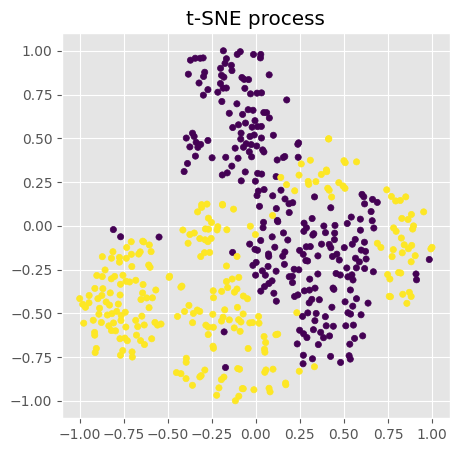

In [66]:
# This is the visilization of  original images.
t=5
b=256
model = UNet(1, 96, 1, (1, 2, 2), 2, (False, True, False))
model.to(device)
train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
#train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=b, shuffle=False,num_workers=4,pin_memory=True)

x_t_train_dataset_t=torch.zeros([b*2,1,28,28])
labels_1=torch.zeros([b*2])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=b, shuffle=False)
  for step, (images1, labels) in enumerate(train_loader11):

    images1=images1.to(device)
    batch_size=images1.shape[0]
    print(step)
    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)
  plt.savefig('savefig_example_tsne_timestep0.png')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.001s...
[t-SNE] Computed neighbors for 512 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 0.950754
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.996689
[t-SNE] KL divergence after 1000 iterations: 0.368126


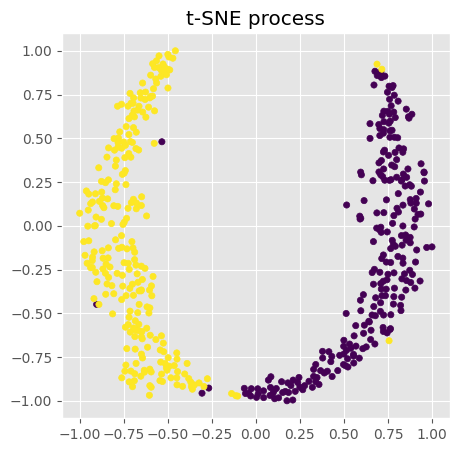

In [67]:
# This is the first layer.
# for t =4
t=4
b=256

train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
#train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=b, shuffle=True,num_workers=4,pin_memory=True)

x_t_train_dataset_t=torch.zeros([b*2,1,28,28])
labels_1=torch.zeros([b*2])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    images1 = transforms.Normalize(0.5,0.5)(model(xt1, time))
    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)
  plt.savefig('savefig_example_tsne_timestep1.png')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.001s...
[t-SNE] Computed neighbors for 512 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 0.636417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.214508
[t-SNE] KL divergence after 1000 iterations: 0.192199


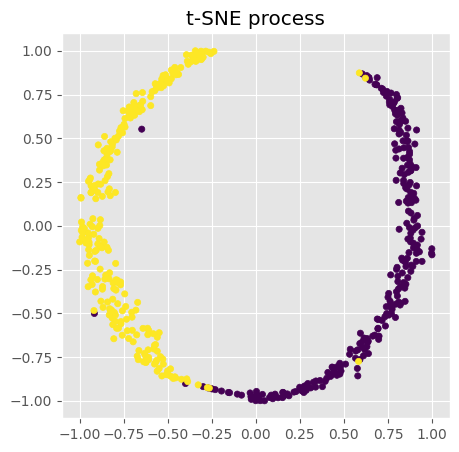

In [68]:
# This is the second layer.
t=3

batch_size=b*2
x_t_train_dataset_t=torch.zeros([b*2,1,28,28])

train_loader11 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=False)
labels_1=torch.zeros([b*2])
model.eval()
with torch.no_grad():
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)

    images1 = transforms.Normalize(0.5,0.5)(model(xt1, time))

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)
  plt.savefig('savefig_example_tsne_timestep2.png')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.001s...
[t-SNE] Computed neighbors for 512 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 0.464716
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.889538
[t-SNE] KL divergence after 1000 iterations: 0.143311


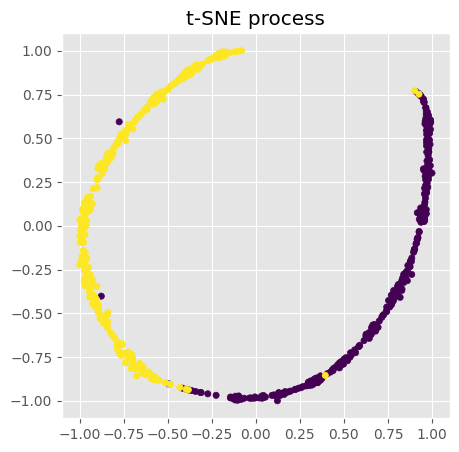

In [69]:
# This is the third layer.
t=2

x_t_train_dataset_t=torch.zeros([b*2,1,28,28])
labels_1=torch.zeros([b*2])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=False)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    images1=transforms.Normalize(0.5,0.5)(model(xt1, time))

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)
  plt.savefig('savefig_example_tsne_timestep3.png')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.001s...
[t-SNE] Computed neighbors for 512 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 0.462111
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.982525
[t-SNE] KL divergence after 1000 iterations: 0.141127


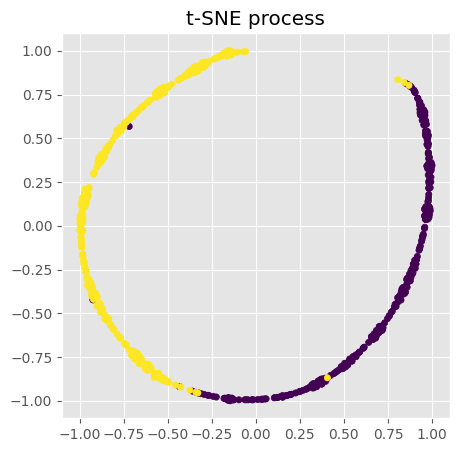

In [70]:
# This is the fourth layer.
t=1

x_t_train_dataset_t=torch.zeros([b*2,1,28,28])
labels_1=torch.zeros([b*2])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=False,num_workers=2,pin_memory=True)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    images1=transforms.Normalize(0.5, 0.5)(model(xt1, time))

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)
  plt.savefig('savefig_example_tsne_timestep4.png')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.001s...
[t-SNE] Computed neighbors for 512 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 0.423969
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.242058
[t-SNE] KL divergence after 950 iterations: 0.143984


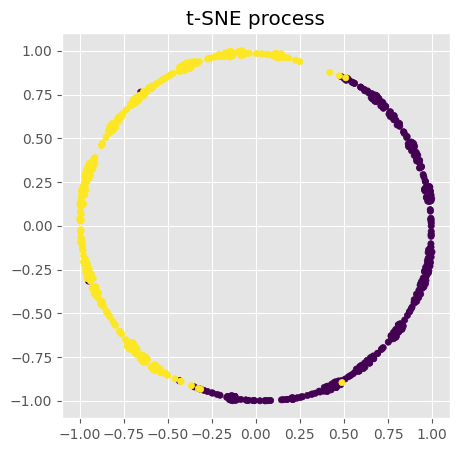

In [71]:
# This is the 5th layer.
t=0

x_t_train_dataset_t=torch.zeros([b*2,1,28,28])
labels_1=torch.zeros([b*2])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=False,num_workers=2,pin_memory=True)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    images1=transforms.Normalize(0.5,0.5)(model(xt1, time))

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)
  plt.savefig('savefig_example_tsne_timestep5.png')